# Probability and Basic Statistics

### Descriptor: Skill Level
1. Able to select an appropriate probability analysis based on nature of the data and business knowledge.
2. Able to understand and apply advanced probability methods, such as Bayes Theorem, random number generation, central limit theorem, etc.
3. Able to choose the correct hypothesis testing and confidence interval approaches for a given business problem.
4. Able to define and perform estimation using techniques such as maximum likelihood estimation (MLE) and least squares.


## 1. Appropriate Probability Analysis


## 2. Advanced Probability Methods


### Bayes Theorem
Describes the probability of an event based on prior knowledge. 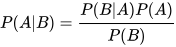
- P(A) or P(B) also known as prior probability
- P(A|B) or P(B|A) a.k.a. posterior probability

### Random Number Generation (RNG)
True randomness is based on natural occuring entropy: atmospheric noise, thermal noise etc

Hardware (HRNG)
- Based on physical/ mechanical action: dice rolling, coin flipping etc.

Pseudo (PRNG)
- Based on initial value which is called seed. May reproduced based on the seed number.

In [29]:
import random
# random.seed(1)
print("randint ", random.randint(1, 100))
print("randrange ", random.randrange(100))
print("random ", random.random())

randint  58
randrange  60
random  0.651592972722763


### Central Limit Theorem
CLT states that the distribution of $\bar{x}$ is approximately normal, $\bar{x}$ ~ $(\mu, \frac{\sigma}{\sqrt{n}})$. This approximation gets better when the sample size increase.

## 3. Hypothesis Testing and Confidence Interval

Implemented in drift analysis for Proxy Well Model (PWM) where we check whether data drift and/ or model drift occur.

## 4. Maximum Likelihood Estimation (MLE)
What is MLE? Estimating the parameters of a probability distribution which maximize the likelihood function.
Why MLE? To make inference about the population.
Where being implemented?